<a href="https://colab.research.google.com/github/SutirthaChakraborty/MatchMiDi/blob/main/MIDIsignatureV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File details-

Dataset
----------
0.csv

1.csv

2.csv

3.csv

4.csv

5.csv


Find Sample
------------
0find.csv

0pitch.csv

0time.csv

In [1]:
!rm -rf data
!rm -rf MixcraftDataset
!rm -rf testingdatapaper/
!rm -rf testingFiles/
!rm -rf dataFiles/

!git clone https://github.com/SutirthaChakraborty/MatchMiDi.git



!pip install py_midicsv
!pip install python-Levenshtein
!unzip /content/MatchMiDi/data.zip
!unzip /content/MatchMiDi/MixcraftDataset.zip
!pip install progressbar
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




Cloning into 'MatchMiDi'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 30 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.
     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp36-cp36m-linux_x86_64.whl size=148891 sha256=de109a41d87e0bda7d4c15e1b575a17b6c0f150c748e9c82fb92898d8ec58d77
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein
Archive:  /content/MatchMiDi/data.zip
  inflating: data/Sco_01_Jupiter_vn_vc.mid  
  inflating: data/Sco_02_Sonata_vn_vn.mid  
  inflating: data/Sco_03_Dance_fl_cl.mid  
  inflating: data/Sco_04_Allegro_fl_fl.mid  
  inflating: data/Sco_05_Entertainer_tpt_tpt.mid  
  inflating: data/Sco_06_Entertainer_sax_sax.mid  
  inflating: data/Sco_07_GString_

In [2]:
import Levenshtein
def distance(tar,total):
    k=[]
    for i in tqdm(range(len(total)-len(tar))):
        k.append(Levenshtein.distance(str(tar),str(total[i:i+len(tar)])))
    # plt.plot(k)
    block=k.index(min(k))
    # print("Minimum value= ",min(k))
    # print("time =", total['Timestamp'].iloc[block+1])
    return k,block


# **Make Dataset**

In [3]:
import py_midicsv as pm
import pandas as pd
import numpy as np
import glob
total=pd.DataFrame()

dataSet=pd.DataFrame()



t=1
files=[]
timediff=[]
pitchData=[]


for file in glob.glob("/content/data/*.mid"):
    files.append(file)
files=sorted(files)


for file in tqdm(files):
    csv_string1 = pm.midi_to_csv(file)
    content = [x.strip().split(', ') for x in csv_string1] 
    data=pd.DataFrame(content)
    data.columns=['A','Timestamp','NotePress','Track','Pitch','Velocity','G']
    y=pd.DataFrame([t] * data.shape[0])
    y.columns=['FileID']
    data=pd.concat([data,y],axis=1)
    total=total.append(data, ignore_index=True)
    t+=1
    total=total[15:-2]
    a=list(total.Track.unique())
    a=filter(None, a) # Remove nulls
    target_Tracks = [ i for i in a if i.isnumeric() ]    # Calculates the number of tracks
    for i in target_Tracks:


        tar=total.loc[total['Track'] == i]
        tar=tar.loc[(tar['NotePress'] == 'Note_off_c') | (tar['NotePress'] == 'Note_on_c') ]
    
        dataSet=dataSet.append(tar, ignore_index=True)
        if(int(i)>-1 and int(i)<=5):
            name= str(i)+".csv"
            tar.to_csv(name)

        if(len(list(np.diff(np.array(tar['Timestamp']).astype(float))))>0):
            pidata=list(tar['Pitch'].astype(float))
            pitchData=pitchData+pidata
            xx=[0]+list(np.diff(np.array(tar['Timestamp']).astype(float)))
            b = (xx - np.min(xx))/np.ptp(xx)
            timediff=timediff+list(b)


len(timediff),len(pitchData)

d=pd.DataFrame(timediff)
d.columns=['TimeDiff']
d.to_csv('timediff.csv')

d=pd.DataFrame(pitchData)
d.columns=['pitchData']
d.to_csv('pitchData.csv')


# **Find Target**

In [75]:
# target_path='/content/MixcraftDataset/File - 03 - 6 sec.mid'
target_path='/content/Song.mid'
import py_midicsv as pm
import pandas as pd
import numpy as np
import glob

tar_timediff=[]
tar_pitchData=[]

timestamp_collector=[]
file_collector=[]
track_collector=[]

blocks=[]


csv_string1 = pm.midi_to_csv(target_path)
content = [x.strip().split(', ') for x in csv_string1] 
data=pd.DataFrame(content)

data.columns=['A','Timestamp','NotePress','Track','Pitch','Velocity','G']
total=data

total=total[15:-2]
a=list(total.Track.unique())
a=filter(None, a) # Remove nulls
target_Tracks = [ i for i in a if i.isnumeric() ]    # Calculates the number of tracks
for i in (target_Tracks):

    tar=total.loc[total['Track'] == i]
    tar=tar.loc[(tar['NotePress'] == 'Note_off_c') | (tar['NotePress'] == 'Note_on_c') ]
    filename=str(i)+'find.csv'
    tar.to_csv(filename)

    if(len(list(np.diff(np.array(tar['Timestamp']).astype(float))))>0):
        pidata=list(tar['Pitch'].astype(float))
        tar_pitchData=tar_pitchData+pidata

        xx=[0]+list(np.diff(np.array(tar['Timestamp']).astype(float)))
        b = (xx - np.min(xx))/np.ptp(xx)
        tar_timediff=tar_timediff+list(b)

        # filename = str(i)+"time.csv"
        # d=pd.DataFrame(tar_timediff)
        # d.columns=['tar_timediff']
        # d.to_csv(filename)

        # filename = str(i)+"pitch.csv"
        # d=pd.DataFrame(tar_pitchData)
        # d.columns=['pitchData']
        # d.to_csv(filename)

        targetfile=str(i)+".csv"
        datasetfile=pd.read_csv(targetfile)

        k,block=distance(pidata,list(datasetfile.Pitch))
        # print(block)
        # b = (k - np.min(k))/np.ptp(k)
        # plt.plot(b)
        # plt.show()
        file_collector.append(datasetfile['FileID'].iloc[block])
        timestamp_collector.append(datasetfile['Timestamp'].iloc[block])
        track_collector.append(datasetfile['Track'].iloc[block])
        blocks.append(block)



# len(tar_timediff),len(tar_pitchData)
track_collector,timestamp_collector,file_collector,blocks

([0, 1], [28800, 28800], [3, 3], [10, 60])

In [76]:
def closest(lst, K): 
	return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 


def most_frequent(List): 
	return max(set(List), key = List.count) 

confirmedfile=most_frequent(file_collector)
print("File : ",most_frequent(file_collector))

print("Time : ",most_frequent(timestamp_collector)) 

	

File :  3
Time :  28800


In [77]:
all_occurrences = []
last_found_index = -1
element_found = True
timelist=[]

# finding out most occured file to confirm the file number

while element_found:
    try:
        last_found_index = file_collector.index(most_frequent(file_collector), last_found_index + 1)
        all_occurrences.append(last_found_index)
    except ValueError:
        element_found = False


# Finding the most likely time to confirm the probable time

for i in range(len(timestamp_collector)):
    if i in all_occurrences:
        timelist.append(timestamp_collector[i])
likely_time=most_frequent(timelist)
print("Most Likely time = ",likely_time )


K = likely_time

# Search the closest midi point from that time  

timestamps=[]
for i in target_Tracks:
    filename=i+'.csv'
    temp=pd.read_csv(filename)
    temp=list(temp.Timestamp)
    timestamps.append(closest(temp,likely_time))

print("Set the closest time in both Tracks: ",timestamps)

Most Likely time =  28800
Set the closest time in both Tracks:  [28800, 28800]


**Correct Value Should be around 20**

We chopped all the MIDI from around 20 secs

In [40]:
# print(60 * 1000000 / 100)  # 100 was the bpm when we edited the dataset
print(600000/likely_time)
print(confirmedfile)

20.833333333333332
3


In [8]:
likely_time

28800

**Getting the timestretch**

In [78]:
file1=pd.read_csv('/content/0.csv')   # dataset
file2=pd.read_csv('0find.csv')       #  target
temp=file1[file1.Timestamp==likely_time]
temp[temp.FileID==confirmedfile]
l=temp[temp.FileID==confirmedfile]
loc=l['Unnamed: 0']
print(loc)

a=float(600000/int(file1.Timestamp.iloc[loc+1-15]))
b=float(600000/int(file1.Timestamp.iloc[loc+2-15]))




# print(b-a)
# c=float(600000/int(file2.Timestamp.iloc[1]))
# d=float(600000/int(file2.Timestamp.iloc[2]))

# print(d-c)

# print(600000/int(file1.Timestamp.iloc[(loc+1)-15]))

# print(600000/int(file1.Timestamp.iloc[(loc+2)-15]))

# print(file1.iloc[loc+1-15])
# print(file1.iloc[loc+2-15])
# print(file1.iloc[loc+3-15])
# # # file2.iloc[0]
# file2

10    25
Name: Unnamed: 0, dtype: int64


    Unnamed: 0  A  Timestamp   NotePress  Track  Pitch  Velocity   G
0           15  2          0   Note_on_c      0     69        70 NaN
1           16  2        500  Note_off_c      0     69         0 NaN
2           17  2       3000   Note_on_c      0     65        72 NaN
3           18  2       3250  Note_off_c      0     65         0 NaN
4           19  2       3500   Note_on_c      0     62        71 NaN
5           20  2       3750  Note_off_c      0     62         0 NaN
6           21  2       4000   Note_on_c      0     65        85 NaN
7           22  2       4500  Note_off_c      0     65         0 NaN
8           23  2       5000   Note_on_c      0     64        71 NaN
9           24  2       5500  Note_off_c      0     64         0 NaN
10          25  2       6000   Note_on_c      0     70        85 NaN
11          26  2       6500  Note_off_c      0     70         0 NaN
12          27  2       7000   Note_on_c      0     69        68 NaN
13          28  2       7500  Note

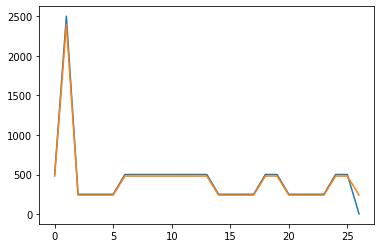

In [79]:
findTime=pd.read_csv('/content/0find.csv')
dataTime=pd.read_csv('/content/0.csv')[int(loc)-15:int(loc)+pd.read_csv('/content/0find.csv').shape[0]-15]

plt.plot(np.diff(np.array(findTime.Timestamp)))
plt.plot(np.diff(np.array(dataTime.Timestamp)))

print(findTime)
print(dataTime)

In [74]:
print(31680-28800)

2880


In [69]:

csv_string1 = pm.midi_to_csv(files[confirmedfile-1])[:15]
csv_string2 = pd.read_csv('/content/0find.csv')
csv_string2.columns=[0,1,2,3,4,5,6,7]
del csv_string2[7]
content = [x.strip().split(', ') for x in csv_string1] 
data=pd.DataFrame(content)
data
csv_string=data.append(csv_string2, ignore_index=True)
# csv_string.to_csv('sample.csv')


# kk=csv_string.to_string(encoding='iso-8859-1')


# midi_object = pm.csv_to_midi(kk)
# with open("example_converted.mid", "wb") as output_file:
#     midi_writer = pm.FileWriter(output_file)
#     midi_writer.write(midi_object)

ValueError: ignored

tick_duration = microseconds_per_beat / ticks_per_beat

tick_duration = 60,000,000 / (beats_per_minute * ticks_per_beat)

microseconds = ticks * tick_duration

In [ ]:
file1.iloc[loc+1]